# RecDP LLM - Decontamination (global deduplication)

Detect and reduce duplication based on exact same content.
* step1: Insert global_id and global hash to origal dataste, convert data to parquet
  * Generate sha256 hash for text in each document
  * Generate byte_size of text in each document
  * Generate global_id for each document (used to index documents)
  * Generate source column to indicate the original source of this data
* step2: do necessary text process, such as:
  * pii removal
  * text fixer
* step3: Generate global hash-indexing for partial of the data
* step4: Aggregate hash-indexing and duplication list
* step5: Apply duplication list for document reduction

# Get started

## 1. Install pyrecdp and dependencies

In [ ]:
! DEBIAN_FRONTEND=noninteractive apt-get install -y openjdk-8-jre
! pip install pyrecdp --pre
# ! pip install 'git+https://github.com/intel/e2eAIOK.git#egg=pyrecdp&subdirectory=RecDP'

## 2. Prepare your own data

In [ ]:
%mkdir -p /content/test_data
%cd /content/test_data
file_names = ['NIH_sample.jsonl']
file_list = [f"https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/PILE/{i}" for i in file_names]
file_names = ['tiny_c4_sample.jsonl', 'tiny_c4_sample_for_pii.jsonl']
file_list += [f"https://raw.githubusercontent.com/intel/e2eAIOK/main/RecDP/tests/data/llm_data/{i}" for i in file_names]
!wget -P /content/test_data {" ".join(file_list)}

## 3. Global Deduplication

### 3.1 PIPELINE based API

2023-10-31 21:55:16.939 | WARNING  | pyrecdp.LLM.TextPipeline:enable_statistics:210 - Enabling this option will result in a decrease in execution speed


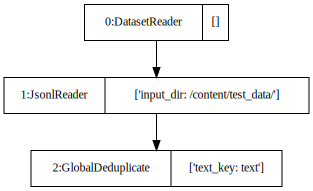

In [7]:
from pyrecdp.LLM import TextPipeline, ResumableTextPipeline
from pyrecdp.primitives.operations import *

pipeline = ResumableTextPipeline()
pipeline.enable_statistics()
ops = [
    JsonlReader("/content/test_data/"),
    GlobalDeduplicate(text_key='text'),
]
pipeline.add_operations(ops)
pipeline.plot()

In [8]:
ret = pipeline.execute()

[DatasetReader, GlobalJsonlReader, GlobalDeduplicateGenDict, PerfileSourcedJsonlReader, GlobalDeduplicateApplyDict, PerfileParquetWriter]
Will assign 1 cores and 10386 M memory for spark
per core memory size is 10.143 GB and shuffle_disk maximum capacity is 8589934592.000 GB
execute with spark for global tasks started ...
DatasetReader
GlobalJsonlReader
GlobalDeduplicateGenDict
statistics_decorator spark
2023-10-31 21:56:32.938 | INFO     | pyrecdp.LLM.TextPipeline:execute:361 - DatasetReader: A total of 0 rows of data were processed, using 0 seconds, with 0 rows modified or removed, 0 rows of data remaining.
2023-10-31 21:56:32.948 | INFO     | pyrecdp.LLM.TextPipeline:execute:361 - GlobalJsonlReader: A total of 0 rows of data were processed, using 0 seconds, with 0 rows modified or removed, 0 rows of data remaining.
2023-10-31 21:56:32.999 | INFO     | pyrecdp.LLM.TextPipeline:execute:361 - GlobalDeduplicateGenDict: A total of 10467 rows of data were processed, using 48.2260727882385

ResumableTextPipeline, current on tiny_c4_sample_for_pii.jsonl:   0%|          | 0/3 [00:00<?, ?it/s]

tiny_c4_sample_for_pii.jsonl
GlobalDeduplicateApplyDict
statistics_decorator spark
2023-10-31 21:56:43.665 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - GlobalDeduplicateApplyDict: A total of 18 rows of data were processed, using 6.560659885406494 seconds, with 0 rows modified or removed, 18 rows of data remaining.
2023-10-31 21:56:43.670 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - PerfileParquetWriter: A total of 0 rows of data were processed, using 0 seconds, with 0 rows modified or removed, 0 rows of data remaining.


ResumableTextPipeline, current on tiny_c4_sample.jsonl:  33%|███▎      | 1/3 [00:09<00:19,  9.83s/it]        

tiny_c4_sample.jsonl
GlobalDeduplicateApplyDict
statistics_decorator spark
2023-10-31 21:56:46.421 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - GlobalDeduplicateApplyDict: A total of 467 rows of data were processed, using 8.715978860855103 seconds, with 17 rows modified or removed, 450 rows of data remaining.
2023-10-31 21:56:46.428 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - PerfileParquetWriter: A total of 0 rows of data were processed, using 0 seconds, with 0 rows modified or removed, 0 rows of data remaining.


ResumableTextPipeline, current on NIH_sample.jsonl:  67%|██████▋   | 2/3 [00:12<00:05,  5.67s/it]    

NIH_sample.jsonl
GlobalDeduplicateApplyDict
statistics_decorator spark
2023-10-31 21:56:49.859 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - GlobalDeduplicateApplyDict: A total of 10467 rows of data were processed, using 11.336827516555786 seconds, with 19 rows modified or removed, 10448 rows of data remaining.
2023-10-31 21:56:49.865 | INFO     | pyrecdp.LLM.TextPipeline:execute:400 - PerfileParquetWriter: A total of 0 rows of data were processed, using 0 seconds, with 0 rows modified or removed, 0 rows of data remaining.


ResumableTextPipeline, current on NIH_sample.jsonl: 100%|██████████| 3/3 [00:16<00:00,  5.34s/it]

2023-10-31 21:56:49.874 | INFO     | pyrecdp.LLM.TextPipeline:execute:405 - Completed! ResumableTextPipeline will not return dataset, please check ResumableTextPipeline_output_20231031215523 for verification.


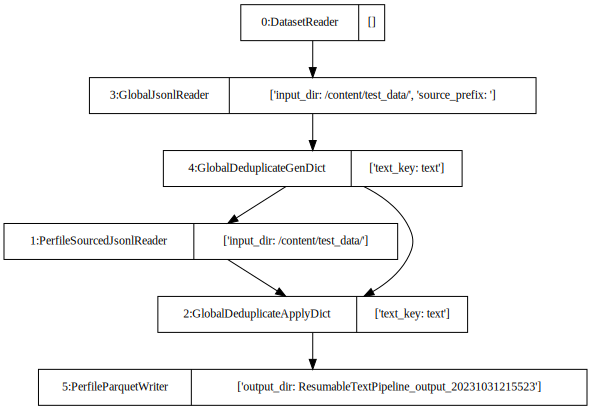

In [9]:
pipeline.plot()

In [10]:
del pipeline

### 3.2 Global Deduplication - step by step

#### 3.2.1 Insert global_id and global hash to origal dataste, convert data to parquet

In [ ]:
from pyrecdp.primitives.llmutils import global_hash_mp
import pandas as pd

source = 'PILE-NIH'
in_type = 'jsonl'
n_parallel = 4
is_norm = True
out_dir = "/content/test_data_with_hashidx/"
data_dir = "/content/test_data/"

global_hash_mp(source, data_dir, in_type, n_parallel, out_dir, is_norm)

pdf = pd.read_parquet(out_dir)
display(pdf)

resetting to 4 for number of processes


global_hash.py: 100%|██████████| 1/1 [00:00<00:00, 184.37it/s]


,text,meta,source,doc_id,hash,bytesize
0,The National Domestic Violence Hotline (NDVH) ...,{'APPLICATION_ID': 100065},PILE-NIH_NIH_sample.jsonl,NIH_sample.jsonl@1,bf1acc6a7abb6cdfdc8157f3f0ddae7a344b4618949429...,1460
1,"The Office of Planning, Research and Evaluatio...",{'APPLICATION_ID': 100066},PILE-NIH_NIH_sample.jsonl,NIH_sample.jsonl@2,4ab814d1699f93fb9d7500f7216065c3d870526aae0637...,3181
2,Improving outcomes for low-income fathers and ...,{'APPLICATION_ID': 100067},PILE-NIH_NIH_sample.jsonl,NIH_sample.jsonl@3,1ec7d83045ce5002e2692acdb30a204292c02da7fd65f5...,1777
3,This project is implementing 36-month follow-u...,{'APPLICATION_ID': 100068},PILE-NIH_NIH_sample.jsonl,NIH_sample.jsonl@4,20deec0fa0d5f4995357049d3110ef1fe661579b2ea4a4...,1760
4,The CCDF Policies Database is a source of info...,{'APPLICATION_ID': 100069},PILE-NIH_NIH_sample.jsonl,NIH_sample.jsonl@5,6581b71fc72f4c94bb743a029478291cba4cadf576155e...,2157
...,...,...,...,...,...,...
9995,Project: Research and produce a videotape that...,{'APPLICATION_ID': 2120612},PILE-NIH_NIH_sample.jsonl,NIH_sample.jsonl@9996,1fa5db880d2a122674fdebc4ecd39b056e2d96d3957f60...,1241
9996,While relapse prevention has been studied and ...,{'APPLICATION_ID': 2120613},PILE-NIH_NIH_sample.jsonl,NIH_sample.jsonl@9997,79247d33552267e1cb0a2a5af570d28e8f55c555b342d4...,1281
9997,"The proposed study on recruitment, adherence a...",{'APPLICATION_ID': 2120616},PILE-NIH_NIH_sample.jsonl,NIH_sample.jsonl@9998,fae920171a632df483a495172cc4085da8ec1232c30334...,2867
9998,Recent studies suggest that HIV epidemics are ...,{'APPLICATION_ID': 2120620},PILE-NIH_NIH_sample.jsonl,NIH_sample.jsonl@9999,6890265c9bfcb7c1eff700c2a99982d1298adce6c9e876...,2424


#### 3.2.2 Generate global hash-indexing for partial of the data

In [ ]:
from pyrecdp.primitives.llmutils.global_dedup import get_hash_indexing

data_dir = "/content/test_data_with_hashidx/"
out_dir = "/content/test_data_hash_indexing"

get_hash_indexing(data_dir, out_dir)

pdf = pd.read_parquet(out_dir)
display(pdf)

Will assign 1 cores and 10386 M memory for spark
per core memory size is 10.143 GB and shuffle_disk maximum capacity is 8589934592.000 GB
Index has been written to /content/test_data_hash_indexing
  Total processed documents count is 10000
  Total distinct hash count is 9998


,hash,doc_id_list,source_list,hash_count
0,0006ff775e92490fb1376665bd3639339492f0c351a27b...,[NIH_sample.jsonl@310],[PILE-NIH_NIH_sample.jsonl],1
1,000f8eb9134390f609bd8edd15c8b73ac4f7d526de3de1...,[NIH_sample.jsonl@638],[PILE-NIH_NIH_sample.jsonl],1
2,000f989ea6ad3c0ccceb078120cc548d89560dc967ee5d...,[NIH_sample.jsonl@7661],[PILE-NIH_NIH_sample.jsonl],1
3,0011cc1072f2abbf418c1b6a89c8d03c819f9dc98e8033...,[NIH_sample.jsonl@2606],[PILE-NIH_NIH_sample.jsonl],1
4,00166f5baee51431d4809219b5b58bc8326f969a4755e9...,[NIH_sample.jsonl@6191],[PILE-NIH_NIH_sample.jsonl],1
...,...,...,...,...
9993,ffc606eef9a73d369cd6a62a489c21433d7e2f45c500a7...,[NIH_sample.jsonl@6775],[PILE-NIH_NIH_sample.jsonl],1
9994,ffcccf1ccd3790b4f7811bde9efb0999ab849693121d0a...,[NIH_sample.jsonl@5209],[PILE-NIH_NIH_sample.jsonl],1
9995,ffe01080e17553690c52f11470efcd2223aed86b052f81...,[NIH_sample.jsonl@8643],[PILE-NIH_NIH_sample.jsonl],1
9996,ffeccb634a3014981cfa913461f1d75faf274f142e01c9...,[NIH_sample.jsonl@2670],[PILE-NIH_NIH_sample.jsonl],1


#### 3.2.3 Aggregate hash-indexing and duplication list

In [ ]:
# optional: combine your hash_indexing if it is created based on different sub data source.
from pyrecdp.primitives.llmutils.global_dedup import combine_hash_indexing

out_dir = "/content/combined_hash_index/"
data_dir_dir = ["/content/test_data_hash_indexing", "/content/test_data_hash_indexing"]

combine_hash_indexing(data_dir_dir, out_dir)

pdf = pd.read_parquet(out_dir)
display(pdf)

Will assign 1 cores and 10386 M memory for spark
per core memory size is 10.143 GB and shuffle_disk maximum capacity is 8589934592.000 GB
Index has been written to /content/combined_hash_index/
  Total hash count from different source is 19996
  Total distinct hash count is 9998


,hash,doc_id_list,source_list,hash_count
0,0006ff775e92490fb1376665bd3639339492f0c351a27b...,"[NIH_sample.jsonl@310, NIH_sample.jsonl@310]","[PILE-NIH_NIH_sample.jsonl, PILE-NIH_NIH_sampl...",2
1,000f8eb9134390f609bd8edd15c8b73ac4f7d526de3de1...,"[NIH_sample.jsonl@638, NIH_sample.jsonl@638]","[PILE-NIH_NIH_sample.jsonl, PILE-NIH_NIH_sampl...",2
2,000f989ea6ad3c0ccceb078120cc548d89560dc967ee5d...,"[NIH_sample.jsonl@7661, NIH_sample.jsonl@7661]","[PILE-NIH_NIH_sample.jsonl, PILE-NIH_NIH_sampl...",2
3,0011cc1072f2abbf418c1b6a89c8d03c819f9dc98e8033...,"[NIH_sample.jsonl@2606, NIH_sample.jsonl@2606]","[PILE-NIH_NIH_sample.jsonl, PILE-NIH_NIH_sampl...",2
4,00166f5baee51431d4809219b5b58bc8326f969a4755e9...,"[NIH_sample.jsonl@6191, NIH_sample.jsonl@6191]","[PILE-NIH_NIH_sample.jsonl, PILE-NIH_NIH_sampl...",2
...,...,...,...,...
9993,ffc606eef9a73d369cd6a62a489c21433d7e2f45c500a7...,"[NIH_sample.jsonl@6775, NIH_sample.jsonl@6775]","[PILE-NIH_NIH_sample.jsonl, PILE-NIH_NIH_sampl...",2
9994,ffcccf1ccd3790b4f7811bde9efb0999ab849693121d0a...,"[NIH_sample.jsonl@5209, NIH_sample.jsonl@5209]","[PILE-NIH_NIH_sample.jsonl, PILE-NIH_NIH_sampl...",2
9995,ffe01080e17553690c52f11470efcd2223aed86b052f81...,"[NIH_sample.jsonl@8643, NIH_sample.jsonl@8643]","[PILE-NIH_NIH_sample.jsonl, PILE-NIH_NIH_sampl...",2
9996,ffeccb634a3014981cfa913461f1d75faf274f142e01c9...,"[NIH_sample.jsonl@2670, NIH_sample.jsonl@2670]","[PILE-NIH_NIH_sample.jsonl, PILE-NIH_NIH_sampl...",2


In [ ]:
from pyrecdp.primitives.llmutils.global_dedup import get_duplication_list

out_dir = "/content/test_data_duplications_index/"
data_dir = "/content/test_data_hash_indexing"

get_duplication_list(data_dir, out_dir)

pdf = pd.read_parquet(out_dir)
display(pdf)

Will assign 1 cores and 10386 M memory for spark
per core memory size is 10.143 GB and shuffle_disk maximum capacity is 8589934592.000 GB


,hash,doc_id
0,cbf6bdde4c26dcfcc289e66dd2808a36d917827d1277ac...,NIH_sample.jsonl@9026
1,f885d6525920cf293bba730b788c60c5f3b9978af1420a...,NIH_sample.jsonl@1769


#### 3.2.4 Apply duplication list for document reduction

In [ ]:
from pyrecdp.primitives.llmutils import index_based_reduction
in_dir =  "/content/test_data_with_hashidx/"
dup_dir = "/content/test_data_duplications_index/"
out_dir = "/content/test_data_after_deduplication/"

index_based_reduction(in_dir, dup_dir, out_dir)

pdf = pd.read_parquet(out_dir)
display(pdf)

Will assign 1 cores and 10386 M memory for spark
per core memory size is 10.143 GB and shuffle_disk maximum capacity is 8589934592.000 GB
Before dedup num_docs is 10000
after dedup num_docs is 9998
file saved to /content/test_data_after_deduplication/


,doc_id,hash,text,meta,source,bytesize
0,NIH_sample.jsonl@1,bf1acc6a7abb6cdfdc8157f3f0ddae7a344b4618949429...,The National Domestic Violence Hotline (NDVH) ...,{'APPLICATION_ID': 100065},PILE-NIH_NIH_sample.jsonl,1460
1,NIH_sample.jsonl@2,4ab814d1699f93fb9d7500f7216065c3d870526aae0637...,"The Office of Planning, Research and Evaluatio...",{'APPLICATION_ID': 100066},PILE-NIH_NIH_sample.jsonl,3181
2,NIH_sample.jsonl@3,1ec7d83045ce5002e2692acdb30a204292c02da7fd65f5...,Improving outcomes for low-income fathers and ...,{'APPLICATION_ID': 100067},PILE-NIH_NIH_sample.jsonl,1777
3,NIH_sample.jsonl@4,20deec0fa0d5f4995357049d3110ef1fe661579b2ea4a4...,This project is implementing 36-month follow-u...,{'APPLICATION_ID': 100068},PILE-NIH_NIH_sample.jsonl,1760
4,NIH_sample.jsonl@5,6581b71fc72f4c94bb743a029478291cba4cadf576155e...,The CCDF Policies Database is a source of info...,{'APPLICATION_ID': 100069},PILE-NIH_NIH_sample.jsonl,2157
...,...,...,...,...,...,...
9993,NIH_sample.jsonl@9996,1fa5db880d2a122674fdebc4ecd39b056e2d96d3957f60...,Project: Research and produce a videotape that...,{'APPLICATION_ID': 2120612},PILE-NIH_NIH_sample.jsonl,1241
9994,NIH_sample.jsonl@9997,79247d33552267e1cb0a2a5af570d28e8f55c555b342d4...,While relapse prevention has been studied and ...,{'APPLICATION_ID': 2120613},PILE-NIH_NIH_sample.jsonl,1281
9995,NIH_sample.jsonl@9998,fae920171a632df483a495172cc4085da8ec1232c30334...,"The proposed study on recruitment, adherence a...",{'APPLICATION_ID': 2120616},PILE-NIH_NIH_sample.jsonl,2867
9996,NIH_sample.jsonl@9999,6890265c9bfcb7c1eff700c2a99982d1298adce6c9e876...,Recent studies suggest that HIV epidemics are ...,{'APPLICATION_ID': 2120620},PILE-NIH_NIH_sample.jsonl,2424
